<a href="https://colab.research.google.com/github/MHaley206265/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/Matt_Haley_DSPT6_224_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys

!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

     |████████████████████████████████| 81kB 2.1MB/s 
     |████████████████████████████████| 266kB 2.7MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 604kB 8.2MB/s 
     |████████████████████████████████| 3.1MB 14.3MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 296kB 38.2MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=b2b355f1d3431e5cf37f02b7d67cb9a63764acfc2e5f13cf3790099cd61933bd
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for confuse: filename=confuse-1.1.0-cp36-none-any.whl size=17574 sha256=c7151097c0a6bee8b9d9c39d01873bcbf021a2e4a4216f17145153cb5191c8b7
  Stored in directory: /root/.cache/pip/wheels/f6/8b/23/41a1b516f6d8d4cc81f5bdb55394a47cdbe9659c53668d3c9e
  Created wheel for imagehash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=291990 sha256

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(train, minimal=True).to_notebook_iframe()

# profile

In [0]:
import category_encoders as ce
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import all_estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# target
target = 'status_group'

In [0]:
def drop_columns(df):

  df = df.copy()
  drop = ['num_private', 'recorded_by', 'payment_type', 'quantity_group', 'id']
  
  df = df.drop(columns=drop)

  return df

In [0]:
# convert date_recorded to just year_recorded
def date_to_year(df):

  df = df.copy()
  df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True)
  df['year_recorded'] = df['date_recorded'].dt.year
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day
  
  df['years'] = df['year_recorded'] - df['construction_year']
  df['years_MISSING'] = df['years'].isnull()

  df = df.drop(columns=['date_recorded'])

  return df

In [0]:
# convert funder to funded_by_gov
 
# At locations where the neighborhood is NOT in the top 10,

def decrease_card(df):

  df = df.copy()
  # funded_by_gov
  df.loc[df['funder']!='Government Of Tanzania', 'funder'] = 'other'
  # installed_by_dwe
  df.loc[df['installer']!='DWE', 'installer'] = 'other'

  return df

In [0]:
# change -2e-08 values to 0 in latitude

def change_to_zero(df):

    df = df.copy()
    df['latitude'] = df['latitude'].replace(-2e-08, 0)
  
    return df

In [0]:
# use ordinal encoder on ['ward', 'lga', 'scheme_name']

def ord_encode(df):
  enc = ce.ordinal.OrdinalEncoder(handle_missing='return_nan')

  df = df.copy()
  df[['ward', 'lga', 'scheme_name']] = enc.fit_transform(df[['ward', 'lga', 'scheme_name']])

  return df

In [0]:
# convert 0 to nan in ['latitude', 'longitude', 'construction_year']

def zero_to_nan(df):

  df = df.copy()
  cols_with_zeros = ['longitude', 'latitude', 'construction_year']
  
  for col in cols_with_zeros:
    df[col] = df[col].replace(0, np.nan)
  
  return df

In [0]:
def train_val(df):

  df = df.copy()
  train, val = train_test_split(df, train_size=.80, test_size=.20, 
                   stratify=df['status_group'], random_state=42)
  
  return train, val

In [0]:
def engineer(df):

  df = df.copy()
  df = drop_columns(df)
  df = date_to_year(df)
  #df = decrease_card(df)
  df = change_to_zero(df)
  #df = ord_encode(df)
  df = zero_to_nan(df)

  return df


In [0]:
def train_val_test(train, test):

  train, val = train_val(train)
  train = engineer(train)
  val = engineer(val)
  test = engineer(test)

  return train, val, test

In [0]:
def get_features(df):
  
  df = df.copy()
  train_features = df.drop(target, axis=1)
  numeric_features = train_features.select_dtypes(include='number').columns.tolist()
  cardinality = train_features.select_dtypes(exclude='number').nunique().index.tolist()
  #categorical_features = cardinality[cardinality <= 50].index.tolist()
  features = numeric_features + cardinality

  return features

In [0]:
def mat_vect(df, features):

  df = df.copy()
  X = df[features]
  y = df[target]

  return X, y

In [0]:
def prepare(train, test):

  train = train.copy()
  test = test.copy()
  train, val, test = train_val_test(train, test)
  features = get_features(train)
  X_train, y_train = mat_vect(train, features)
  X_val, y_val = mat_vect(val, features)
  test = test[features]

  return X_train, y_train, X_val, y_val, test

In [0]:
def kaggle_sub(df, pipe, test):
    X_test = df.copy()
    y_pred = pipe.predict(X_test)

    submission = test[['id']].copy()
    submission['status_group'] = y_pred
    submission.to_csv('my_submission.csv', index=False)

In [0]:
X_train, y_train, X_val, y_val, X_test = prepare(train, test)

In [0]:
pipe = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=2,
                           min_samples_split=6, max_features=0.18340450985343382, max_depth = 20)
)

In [0]:
# param_grid = {
#     'randomforestclassifier__max_depth': [20, 22, 24, 26, 28], 
# }

# rscv = RandomizedSearchCV(pipe, param_grid, random_state=42)

# search = rscv.fit(X_train, y_train)

# print(f'Best Parameters: {search.best_params_}')
# print(f'Best Score: {search.best_score_}')

In [0]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantit...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20,
                                        max_features=0

In [0]:
from sklearn.metrics import plot_confusion_matrix

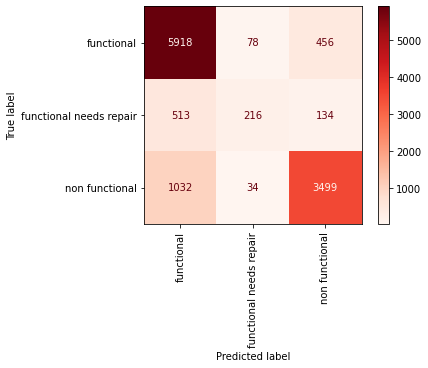

In [0]:
plot_confusion_matrix(pipe, X_val, y_val, values_format='.0f', cmap='Reds',
                      xticks_rotation='vertical');

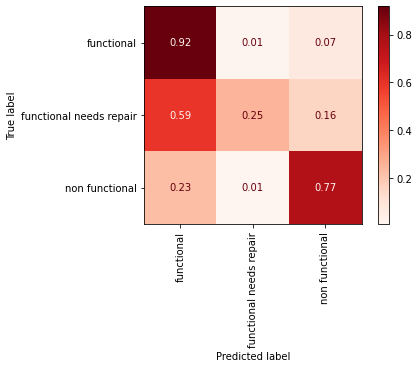

In [0]:
plot_confusion_matrix(pipe, X_val, y_val, values_format='.2f', cmap='Reds',
                      xticks_rotation='vertical', normalize='true');

In [0]:
pipe.score(X_val, y_val)

0.8108585858585858

In [0]:
pipe.score(X_train, y_train)

0.9147306397306397

In [0]:
X_test.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year', 'year_recorded',
       'month_recorded', 'day_recorded', 'years', 'funder', 'installer',
       'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'years_MISSING'],
      dtype='object')

In [0]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year', 'year_recorded',
       'month_recorded', 'day_recorded', 'years', 'funder', 'installer',
       'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'years_MISSING'],
      dtype='object')

In [0]:
X_train.shape, X_test.shape

((47520, 39), (14358, 39))

In [0]:
# y_pred = pipe.predict(X_test)

# submission = test[['id']].copy()
# submission['status_group'] = y_pred
# submission.to_csv('my_submission_new.csv', index=False)